In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

%matplotlib inline

2024-02-16 15:41:23.877448: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-16 15:41:23.900378: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-16 15:41:23.900402: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-16 15:41:23.900418: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-16 15:41:23.904614: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-16 15:41:23.905151: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
# Get in dataset
data_features_test = pd.read_csv("/home/knel/virtual_envs/ankh-morpork/ICS_data_generation/data/csvDataFeaturesTest.csv", sep=";")

# Take out only data corresponing to attacks and remove the column labelling it as an attack
data_features_attacks = data_features_test.to_numpy()[238279:, :-1]
print(np.count_nonzero(np.isnan(data_features_attacks)))
# Set negative values to 0
data_features_attacks = np.where(data_features_attacks >= 0, data_features_attacks, 0)
data_features_attacks = data_features_attacks.reshape((9999,21,1)).astype('float32')

0


In [3]:
# based on Austrian dataset
batch_size = 21
features = 21
# what is sequence length actually representing here
seq_length = 5

In [4]:
# shuffle prevents model from getting stuck in local minima when solving the loss function
train_dataset = (tf.data.Dataset.from_tensor_slices(data_features_attacks[:9000]).shuffle(10000).batch(batch_size))

In [5]:
def make_generator_model():
    model = tf.keras.Sequential()
    # LSTM hidden layer with 100 memory units
    model.add(tf.keras.layers.LSTM(200, input_shape = (seq_length, features), recurrent_dropout=0.4, return_sequences=True))
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.LSTM(200, recurrent_dropout=0.4))
    model.add(tf.keras.layers.ReLU())
    # dropout layer with a probability of 20
    # model.add(tf.keras.layers.Dropout(0.2))
    # output dense (fully connected) layer
    model.add(tf.keras.layers.Dense(features, activation="tanh"))
    return model

In [6]:
generator = make_generator_model()
# what do we want to the generator to output? One packet at a time? One attack at a time?
# what to use as noise - what kind of dimension?
# BGAN does [batch_size x seq_length, features]
# LSTM expects sequences of the form [samples, time steps, features]
noise = tf.random.normal((batch_size, seq_length, features))
generated_data_untrained = generator(noise, training=False)
generated_data_untrained.get_shape()

TensorShape([21, 21])

In [7]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(200, input_shape=(21,1), recurrent_dropout=0.4, return_sequences=True))
    model.add(tf.keras.layers.LSTM(200, recurrent_dropout=0.4))
    # model.add(tf.keras.layers.Dropout(0.2))
    # what should the units of this dense layer be?
    # seems like it outputs one value >0 for real data and <0 for fake data
    # for each item in the batch
    model.add(tf.keras.layers.Dense(1, activation="tanh"))
    return model

In [8]:
discriminator = make_discriminator_model()
decision_untrained = discriminator(generated_data_untrained)
decision_untrained

<tf.Tensor: shape=(21, 1), dtype=float32, numpy=
array([[-3.2510402e-04],
       [-1.3755333e-04],
       [ 4.0951702e-05],
       [-1.2896748e-04],
       [-1.7536493e-04],
       [ 8.7374792e-05],
       [-7.9066107e-05],
       [-2.8694759e-04],
       [-1.5438750e-04],
       [-3.7259611e-04],
       [-1.1736051e-04],
       [-1.8924188e-04],
       [-4.3420371e-04],
       [-5.6035504e-05],
       [-2.9455436e-05],
       [-7.2827141e-05],
       [-9.2753471e-05],
       [-1.4813099e-04],
       [-3.8101224e-04],
       [ 7.8819547e-05],
       [-1.7619398e-04]], dtype=float32)>

### Binary Cross Entropy

$$ H_p(q) = -\frac{1}{N} \Sigma_{i=1}^N y_i log(p(y_i)) + (1-y_i) log(1-p(y_i)) $$

### BGAN Losses

$$ D_{loss} = \frac{1}{m} \Sigma_{i=1}^m [logD(x_i) + log(1-D(G(z_i)))] $$

$$ G_{loss} = \frac{1}{m} \Sigma_{i=1}^m [log(1-D(G(z_i)))] $$

In [25]:
# define losses (this will change)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # from_logits=True means models prediction represents a value [-inf, inf]

In [10]:
def discriminator_loss(real_data, fake_data):
    real_loss = cross_entropy(tf.ones_like(real_data), real_data)
    fake_loss = cross_entropy(tf.zeros_like(fake_data), fake_data)
    total_loss = real_loss + fake_loss
    return total_loss

    # BGAN loss
    # loss = tf.reduce_mean(tf.math.log(real_data) + tf.math.log(1 - fake_data), axis=None)
    # if tf.math.is_nan(loss):
    #     return 0.0
    # return loss

In [11]:
def generator_loss(fake_data):
    return cross_entropy(tf.ones_like(fake_data), fake_data)

    # BGAN loss
    # loss = tf.reduce_mean(tf.math.log(1 - fake_data))
    # if tf.math.is_nan(loss):
    #     return 0.0
    # return loss

In [12]:
generator_optimiser = tf.keras.optimizers.Adam(1e-4)
discriminator_optimiser = tf.keras.optimizers.Adam(1e-4)

In [13]:
@tf.function
def train_step(data):
    dlosses = []
    glosses = []
    # generate samples from the random space
    noise = tf.random.normal((batch_size, seq_length, features))

    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        generated_data = generator(noise, training=True)

        real_data = discriminator(data, training=True)
        fake_data = discriminator(generated_data, training=True)

        gloss = generator_loss(fake_data)
        dloss = discriminator_loss(real_data, fake_data)
        dlosses.append(dloss)
        glosses.append(gloss)

    generator_gradients = generator_tape.gradient(gloss, generator.trainable_variables)
    discriminator_gradients = discriminator_tape.gradient(dloss, discriminator.trainable_variables)

    generator_optimiser.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimiser.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    return dloss, gloss

In [14]:
noise = tf.random.normal((batch_size, seq_length, features))

In [22]:
epochs = 20

In [16]:
def train(dataset, epochs):
    predictions = np.array([])
    dlosses = []
    glosses = []

    for epoch in range(epochs):
        
        # maybe add another loop for more training rounds
        for data_batch in dataset:
            dloss, gloss = train_step(data_batch)
            dlosses.append(dloss)
            glosses.append(gloss)

        prediction = generator(noise, training=False)
        predictions = np.append(predictions, prediction)

    return predictions, dlosses, glosses

In [26]:
preds, dlosses, glosses = train(train_dataset, epochs=epochs)

In [19]:
preds.shape
preds = preds.reshape(batch_size*epochs, features)

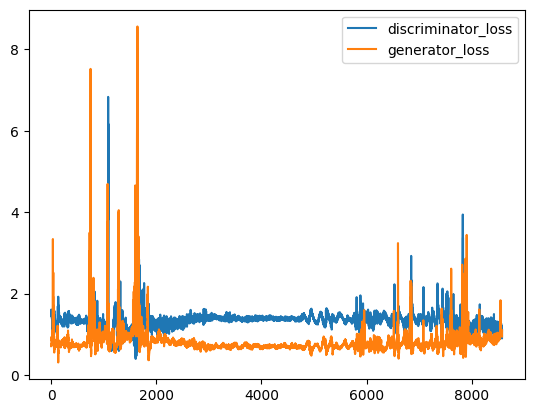

In [27]:
plt.plot(dlosses, label="discriminator_loss")
plt.plot(glosses, label="generator_loss")
# plt.ylim(0,3)
plt.legend()

In [ ]:
# when I increase memory units the losses go insane
# smoother losses using tanh for both activations and non-logit binary crossentropy
# not adding dropout genuinely makes it go insane

In [ ]:
preds[-100:, :], preds.shape

(array([[ 0.28858089, -0.53200185, -0.09985652, ...,  0.88487786,
          0.00372151, -0.19773407],
        [ 0.30767035, -0.53237236, -0.12261962, ...,  0.90010118,
         -0.04944443, -0.18461946],
        [ 0.17316227, -0.29852551, -0.05793002, ...,  0.64103037,
         -0.03231975, -0.13786589],
        ...,
        [ 0.33584216, -0.50798398, -0.11457463, ...,  0.95808649,
          0.05981147, -0.09119136],
        [ 0.16342017, -0.20234156, -0.05361003, ...,  0.76418513,
         -0.06436654, -0.12168261],
        [ 0.30527246, -0.45498353, -0.13436176, ...,  0.95798075,
          0.06301718, -0.11042398]]),
 (630, 21))